In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt





In [4]:
data = np.load("/content/Burgers data.npz")
t_ref, x_ref, exact = data["t"], data["x"], data["usol"].T

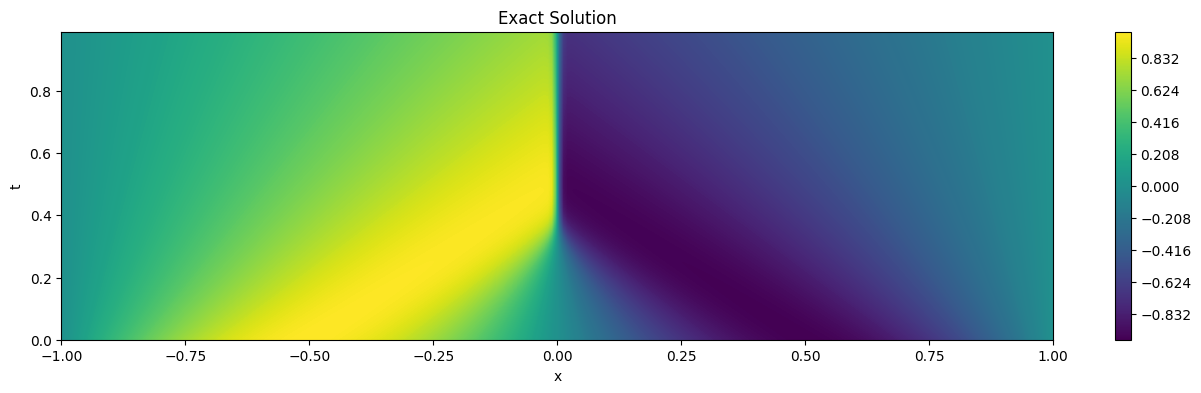

In [5]:
x_ref, t_ref = np.meshgrid(x_ref, t_ref)

plt.figure(figsize=(16, 4))
plt.contourf(x_ref, t_ref, exact, levels=250)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')
plt.show()

## initial condition loss, boundary loss, pde residual loss

initial condirttion loss = discrepency between the neural network and the true initial conition

boundary condition: the neural network satisfies the boundary condition

pde residual loss: the neural network follows the physics laws that is the burgers equaton in this case


add them to make total loss and then minimize that


In [11]:
class PINN(nn.Module):
  def __init__(self):
    super(PINN, self).__init__()
    self.hidden = nn.Sequential(
        nn.Linear(2, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 20),
        nn.Tanh(),
        nn.Linear(20, 1)
    )

  def forward(self, x, t):
    inputs = torch.cat([x, t], dim=1)
    return self.hidden(inputs)

In [7]:
def pde_residual(x, t, model, nu=0.01):
  x.requires_grad_(True)
  t.requires_grad_(True)
  u = model(x, t)
  u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
  u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
  residual = u_t + u * u_x - nu/(np.pi) * u_xx
  return residual

def initial_condition(x, model):
  return -torch.sin(np.pi * x)

def boundary_condition(x, t):
  return torch.zeros_like(t)

In [9]:
x = torch.linspace(-1, 1, 300).view(-1, 1)
t = torch.linspace(0, 1, 200).view(-1, 1)

x_train, t_train = torch.meshgrid(x.squeeze(), t.squeeze(), indexing="xy")
x_train = x_train.reshape(-1, 1)
t_train = t_train.reshape(-1, 1)

In [12]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [15]:
num_epochs = 12000
for epoch in range(num_epochs):
  model.train()


  # initial condition loss
  u_pred = model(x, torch.zeros_like(x))
  u_true = initial_condition(x, model)
  ic_loss = torch.mean((u_pred - u_true)**2)

  # compute boundary condition loss
  u_pred_left = model(torch.full_like(t, -1), t)
  u_pred_right = model(torch.full_like(t, 1), t)
  bc_loss = torch.mean((u_pred_left - boundary_condition(torch.full_like(t, -1), t))**2 + (u_pred_right - boundary_condition(torch.full_like(t, 1), t))**2)

  residual = pde_residual(x_train, t_train, model)
  pde_loss = torch.mean(residual**2)

  total_loss = ic_loss + bc_loss + pde_loss

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if epoch % 500 == 0:
    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.4f}')

Epoch [1/12000], Total Loss: 0.5138
Epoch [501/12000], Total Loss: 0.0703
Epoch [1001/12000], Total Loss: 0.0063
Epoch [1501/12000], Total Loss: 0.0028
Epoch [2001/12000], Total Loss: 0.0035
Epoch [2501/12000], Total Loss: 0.0031
Epoch [3001/12000], Total Loss: 0.0025
Epoch [3501/12000], Total Loss: 0.0006
Epoch [4001/12000], Total Loss: 0.0011
Epoch [4501/12000], Total Loss: 0.0004
Epoch [5001/12000], Total Loss: 0.0004
Epoch [5501/12000], Total Loss: 0.0010
Epoch [6001/12000], Total Loss: 0.0045
Epoch [6501/12000], Total Loss: 0.0003
Epoch [7001/12000], Total Loss: 0.0845
Epoch [7501/12000], Total Loss: 0.0012
Epoch [8001/12000], Total Loss: 0.0009
Epoch [8501/12000], Total Loss: 0.0011
Epoch [9001/12000], Total Loss: 0.0019
Epoch [9501/12000], Total Loss: 0.0006
Epoch [10001/12000], Total Loss: 0.0002
Epoch [10501/12000], Total Loss: 0.0002
Epoch [11001/12000], Total Loss: 0.0018
Epoch [11501/12000], Total Loss: 0.0076


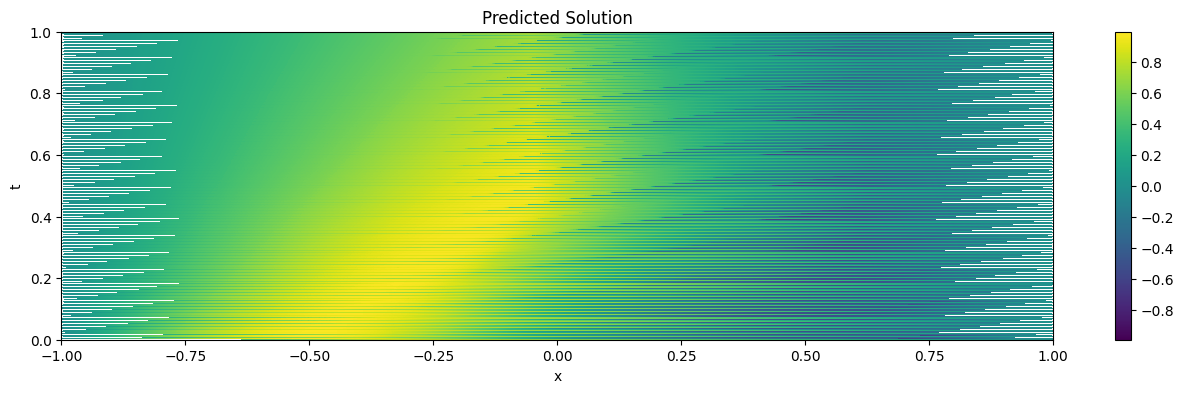

Text(0.5, 1.0, 'Exact Solution')

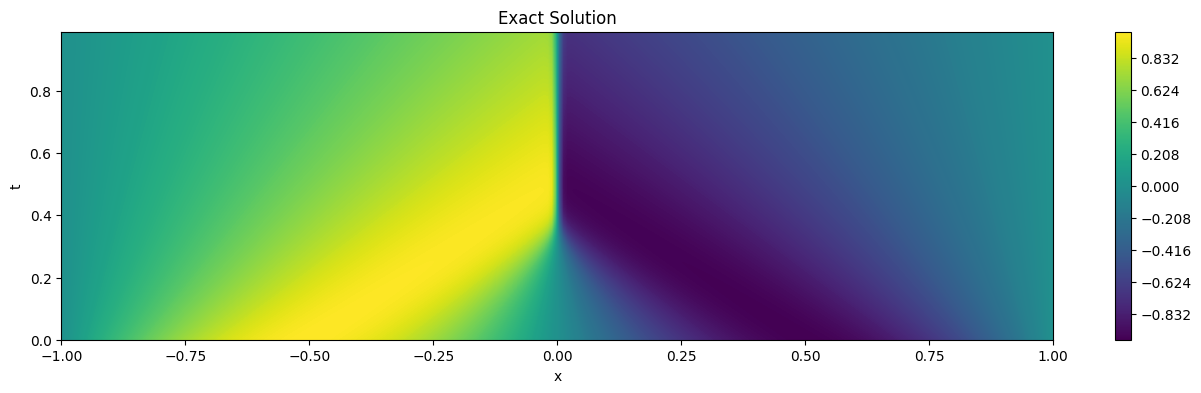

In [16]:
x_test = torch.linspace(-1, 1, 300).view(-1, 1)
t_test = torch.linspace(0, 1, 200).view(-1, 1)

x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="xy")
x_test = x_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)

model.eval()
with torch.no_grad():
  u_pred = model(x_test, t_test).numpy()

x_test = x_test.numpy().reshape(300,200)
t_test = t_test.numpy().reshape(300,200)
u_pred = u_pred.reshape(300,200)

plt.figure(figsize=(16, 4))
plt.contourf(x_test, t_test, u_pred, levels=250)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted Solution')
plt.show()


plt.figure(figsize=(16, 4))
plt.contourf(x_ref, t_ref, exact, levels=250)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')

AttributeError: 'Axes' object has no attribute 'set_xlin'

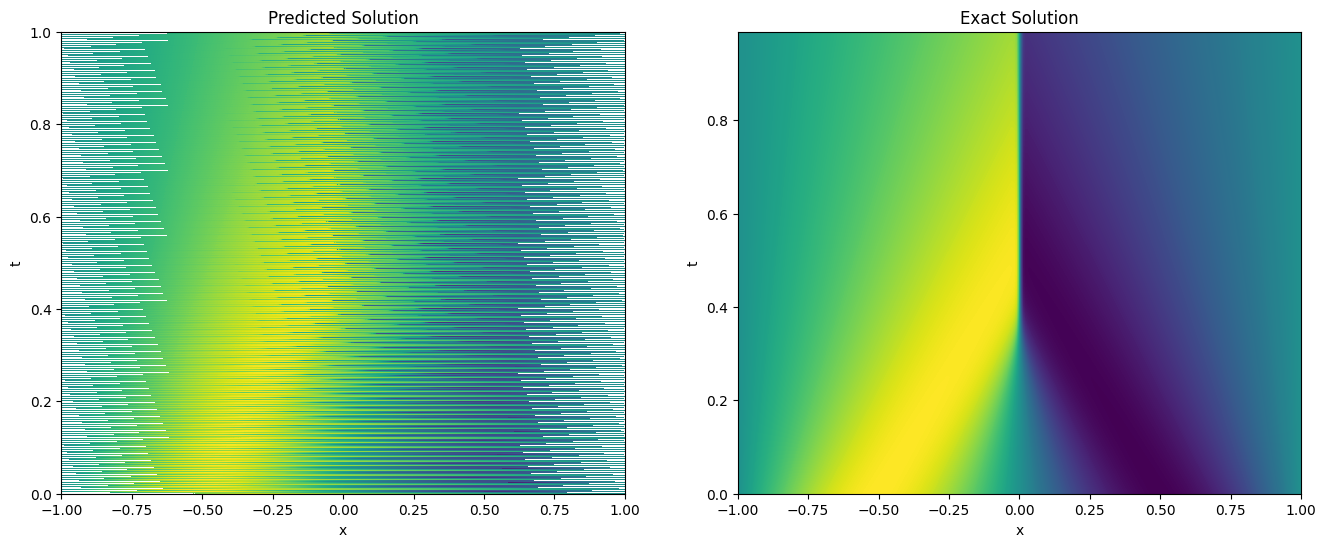

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

contour1 = ax1.contourf(x_test, t_test, u_pred, levels=250)
ax1.set_xlabel('x')
ax1.set_ylabel('t')
ax1.set_title('Predicted Solution')

contour2 = ax2.contourf(x_ref, t_ref, exact, levels=250)
ax2.set_xlabel('x')
ax2.set_ylabel('t')
ax2.set_title('Exact Solution')


ax1.set_xlin([x_ref.min(), x_ref.max()])
ax1.set_ylin([t_ref.min(), t_ref.max()])
ax2.set_xlin([x_ref.min(), x_ref.max()])
ax2.set_ylin([t_ref.min(), t_ref.max()])

plt.tight_layout()
plt.show()

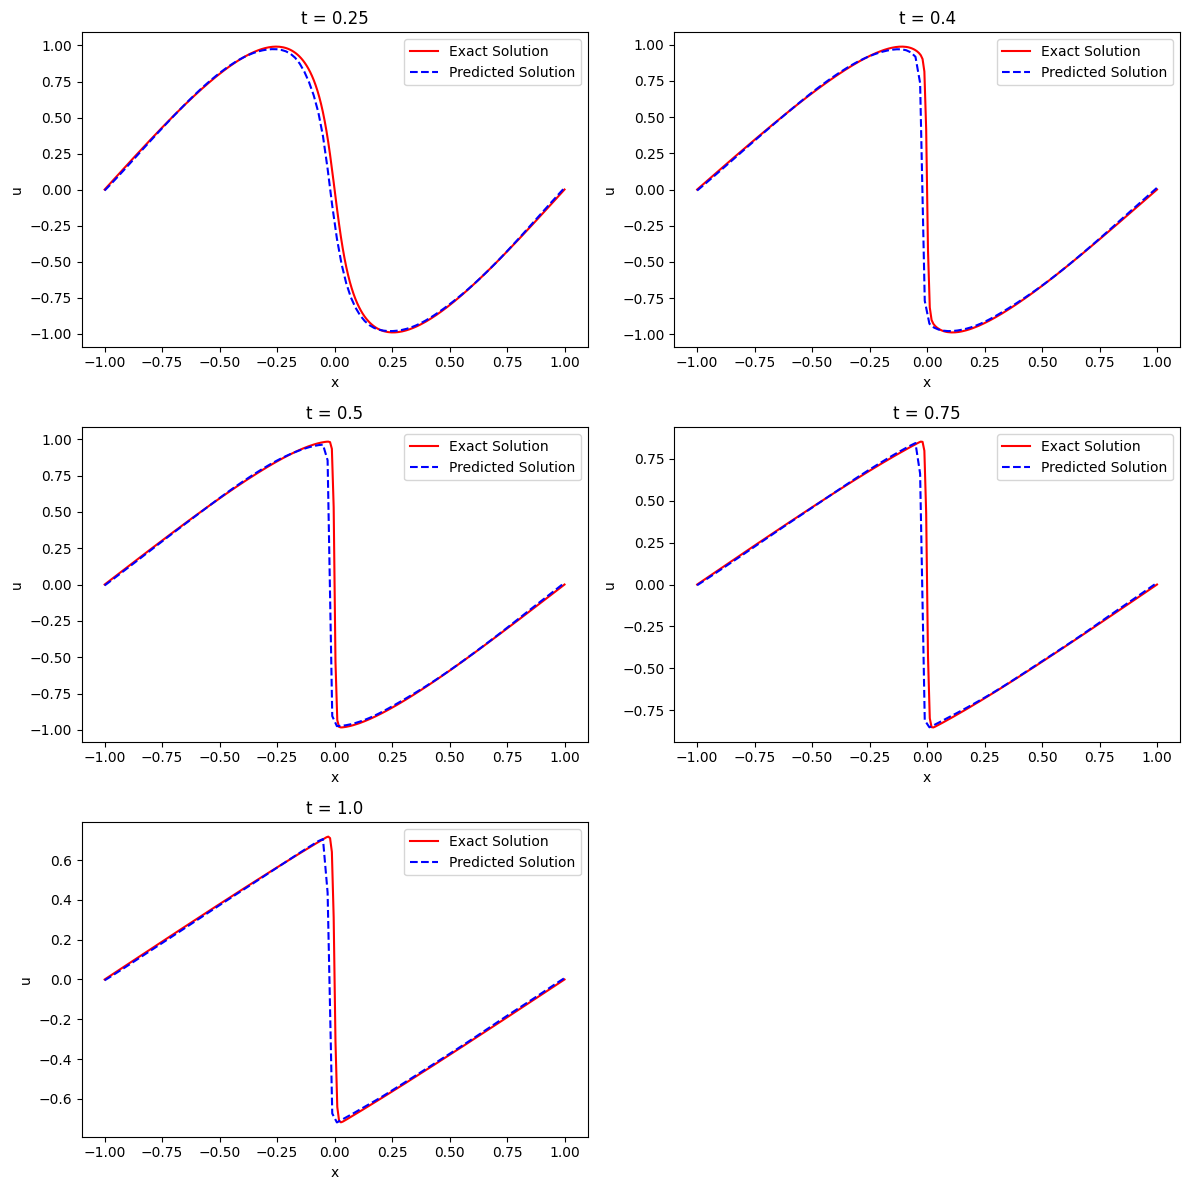

In [20]:
time_slices = [0.25, 0.40, 0.50, 0.75, 1.0]

num_plots = len(time_slices)
cols = 2

rows = (num_plots // cols)+ (num_plots % cols)


fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
axs = axes.flatten()

for i, t_val in enumerate(time_slices):
  idx_ref = np.argmin(np.abs(t_ref[:, 0] - t_val))
  u_ref_slice = exact[idx_ref,:]


  t_slice = t_val * np.ones((100, 1))
  x_slice = np.linspace(-1, 1, 100).reshape(-1, 1)

  model.eval()
  with torch.no_grad():
    u_pred_slice = model(torch.tensor(x_slice, dtype=torch.float32), torch.tensor(t_slice, dtype=torch.float32)).numpy()


    axs[i].plot(x_ref[0,:], u_ref_slice, 'r-', label='Exact Solution')
    axs[i].plot(x_slice, u_pred_slice, 'b--', label='Predicted Solution')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u')
    axs[i].set_title(f't = {t_val}')
    axs[i].legend()

for j in range(num_plots, len(axs)):
  fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
